In [36]:
#import packages
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, roc_auc_score, roc_curve
from sklearn.datasets import make_regression

In [2]:
#import packages
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
import rtree  # supports geospatial join
import os
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
import sys
import pickle
from shapely.ops import nearest_points
from datetime import datetime as dt, date
sys.path.append('/Users/jackepstein/Documents/GitHub/wildfires-1001/code/functions/')
data_dir = '/Users/jackepstein/Documents/GitHub/wildfires-1001/data'
code_dir = '/Users/jackepstein/Documents/GitHub/wildfires-1001/code'

# Pull in main data frame

In [3]:
#pull in the target data frame and weather dictionary 
#make sure to change the pkl file name if needed
target_dict = {}
target_df = gpd.GeoDataFrame()
for i in np.arange(1, 3):
    target_dict[i] = pd.read_pickle(os.path.join(data_dir, f'clean_data/target_df_final_geo_1122_weathereng_{i}.pkl')) 
    target_df = target_df.append(target_dict[i])


weather_dict_path = os.path.join(data_dir, 'clean_data/ERA_weather-data/ERA_rename_dictionary.pkl')

In [4]:
#load the naming dictionary
with open(weather_dict_path, 'rb') as handle:
    rename_dict = pickle.load(handle)

In [5]:
#rename the columns based on this dictionary
target_df.rename(columns = rename_dict, inplace = True)

In [6]:
#create lists of columns to drop and what our targets are
non_mod_cols = ['GRID_ID','month_id','MONTH','COUNTYFP','NAME','GRID_AREA','COUNTY_ARE','COUNTY_AREA',
                'geometry', 'adj_fire_count','adj_fire_bcount', 'Fire_area','Index','index']
bad_features = ['hist_p_time_1m', 'total_fire_days', 'hist_p_time_1y']
Y_cols = ['Y_bin', 'Y_fire_count', 'Y_fire_area_prop', 'Y_fire_class_size']

In [7]:
#convert floats from 64 to 32 for model
for col in target_df.columns:
    if target_df[col].dtypes == 'float64':
        target_df[col] = target_df[col].astype(np.float32)

# Split training and testing data

In [8]:
#generate training data set
#pre 2016
train_data = target_df[target_df['YEAR']<=2016]
X_train = train_data.drop('YEAR', axis = 1)
#drop columns not used for modeling
for y in Y_cols + non_mod_cols + bad_features:
    try:
        X_train.drop(y, inplace = True, axis =1)
    except:
        pass
#set up target variable
Y_train = train_data[['Y_fire_area_prop']]
Y_train_cl = train_data[['Y_bin']]
Y_train_cl_size = train_data[['Y_fire_class_size']]

#generate testing data set - same logic as above
test_data = target_df[target_df['YEAR']>2016]
X_test = test_data.drop('YEAR', axis = 1)
for y in Y_cols + non_mod_cols + bad_features:
    try:
        X_test.drop(y, inplace = True, axis =1)
    except:
        pass
Y_test = test_data[['Y_fire_area_prop']] 
Y_test_cl = test_data[['Y_bin']]
Y_test_cl_size = test_data[['Y_fire_class_size']]

In [9]:
#check for any null values

#null vals array
null = np.zeros(len(X_train.columns))

for i in range(len(X_train.columns)):
    null[i] = X_train.loc[X_train[X_train.columns[i]].isna()].shape[0]
    
np.sum(null)

0.0

# Build OOB RF - Regression

In [21]:
#fit the regression model
rf = RandomForestRegressor()
rf.fit(X_train,Y_train.to_numpy().ravel())

RandomForestRegressor()

In [22]:
#turn y and prediction into arrays
preds_arrays = rf.predict(X_test)
y_test_arr = Y_test.to_numpy()

R^2 value: 0.2591583288873326


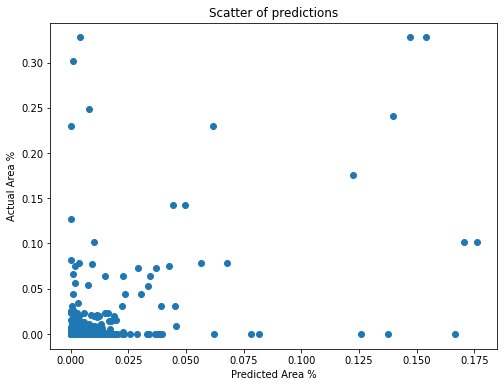

In [23]:
#plot predictions vs actuals
plt.figure(figsize=(8,6))
plt.scatter(preds_arrays, y_test_arr)
plt.title('Scatter of predictions')
plt.xlabel('Predicted Area %')
plt.ylabel('Actual Area %')
#check R^2 value
print("R^2 value:",rf.score(X_test, Y_test))
plt.show()

In [25]:
features = pd.DataFrame()
features['feature'] = X_test.columns
features['feature_score'] = rf.feature_importances_
features.sort_values(by='feature_score', ascending=False)

,feature,feature_score
68,Y_fire_area_prop_prev_month,0.387149
120,2m_tmp_18hrs_5y,0.027129
169,month_id_old,0.024387
55,2m_tmp_18hrs,0.022673
47,2m_tmp_12hrs,0.018708
...,...,...
67,Y_fire_class_size_prev_10yr,0.000165
63,hist_bin_10y,0.000041
61,hist_bin_1y,0.000037
60,hist_bin_1m,0.000029


In [26]:
#send RF regressor to pick

rf_load_path = os.path.join(code_dir, 'model_dev/baseline2_RFregressor_1121JE')

pickle.dump(rf, open(rf_load_path, "wb"))

# Build OOB Random Forest - Class

In [11]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train,Y_train_cl.to_numpy().ravel())

RandomForestClassifier()

In [12]:
y_test_cl_arr = Y_test_cl.to_numpy()
preds_clf = rf_clf.predict(X_test)

#plot confusion
confusion_matrix(y_test_cl_arr, preds_clf)

#get precision and recall scores

array([[2912,   98],
       [ 343,  211]])

In [13]:
#check precision and recall
print(classification_report(y_test_cl_arr, preds_clf))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      3010
           1       0.68      0.38      0.49       554

    accuracy                           0.88      3564
   macro avg       0.79      0.67      0.71      3564
weighted avg       0.86      0.88      0.86      3564



In [14]:
features_clf = pd.DataFrame()
features_clf['feature'] = X_test.columns
features_clf['feature score'] = rf_clf.feature_importances_
features_clf.sort_values(by=['feature score'], ascending=False)

,feature,feature score
64,Y_fire_class_size_prev_month,0.052023
68,Y_fire_area_prop_prev_month,0.043405
60,hist_bin_1m,0.034830
69,Y_fire_area_prop_prev_1yr,0.013724
169,month_id_old,0.013686
...,...,...
9,total_road_length,0.001573
8,road_count,0.001514
27,medianHHI2018,0.001434
4,elev_min,0.001414


# Try Clf only during fire season

In [27]:
#try doing only on months in fire season
#pick may - november
fire_season = target_df.loc[target_df['MONTH']>=5].loc[target_df['MONTH']<=11]

In [28]:
#generate training data set - on fire season
#pre 2016
train_data_v2 = fire_season[fire_season['YEAR']<=2016]
X_train_v2 = train_data_v2.drop('YEAR', axis = 1)
#drop columns not used for modeling
for y in Y_cols + non_mod_cols + bad_features:
    try:
        X_train_v2.drop(y, inplace = True, axis =1)
    except:
        pass
#set up target variable
Y_train_cl_v2 = train_data_v2[['Y_bin']]

#generate testing data set - same logic as above
test_data_v2 = fire_season[fire_season['YEAR']>2016]
X_test_v2 = test_data_v2.drop('YEAR', axis = 1)
for y in Y_cols + non_mod_cols + bad_features:
    try:
        X_test_v2.drop(y, inplace = True, axis =1)
    except:
        pass
Y_test_cl_v2 = test_data_v2[['Y_bin']]

In [29]:
#oob Random forest
rf_clf_2 = RandomForestClassifier()
rf_clf_2.fit(X_train_v2,Y_train_cl_v2.to_numpy().ravel())

RandomForestClassifier()

In [30]:
y_test_cl_arr_2 = Y_test_cl_v2.to_numpy()
preds_clf_2 = rf_clf_2.predict(X_test_v2)

#plot confusion
confusion_matrix(y_test_cl_arr_2, preds_clf_2)

array([[1493,   98],
       [ 286,  202]])

In [31]:
print(classification_report(y_test_cl_arr_2, preds_clf_2))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      1591
           1       0.67      0.41      0.51       488

    accuracy                           0.82      2079
   macro avg       0.76      0.68      0.70      2079
weighted avg       0.80      0.82      0.80      2079



In [32]:
features_clf2 = pd.DataFrame()
features_clf2['feature'] = X_test.columns
features_clf2['feature score'] = rf_clf_2.feature_importances_
features_clf2.sort_values(by=['feature score'], ascending=False)

,feature,feature score
68,Y_fire_area_prop_prev_month,0.040891
64,Y_fire_class_size_prev_month,0.039406
60,hist_bin_1m,0.034562
169,month_id_old,0.017088
72,tot_area_fire_prev_1yr,0.016601
...,...,...
8,road_count,0.001710
0,elev_mean,0.001702
9,total_road_length,0.001434
27,medianHHI2018,0.001283


# Attempting Gradient Boosting

In [17]:
#starting with max depth=2 and 1,000 n_estimators
n_est_lim = 1000
gbc = GradientBoostingClassifier(n_estimators = n_est_lim, max_depth = 2)
gbc.fit(X_train, Y_train_cl.to_numpy().ravel())

GradientBoostingClassifier(max_depth=2, n_estimators=1000)

In [47]:
y_test_cl_arr
preds_gbc = gbc.predict(X_test)
preds_gbc_prob = gbc.predict_proba(X_test)

#plot confusion
print(confusion_matrix(y_test_cl_arr,preds_gbc))

#get precision and recall scores
print(classification_report(y_test_cl_arr, preds_gbc))

[[2825  185]
 [ 303  251]]
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      3010
           1       0.58      0.45      0.51       554

    accuracy                           0.86      3564
   macro avg       0.74      0.70      0.71      3564
weighted avg       0.85      0.86      0.86      3564



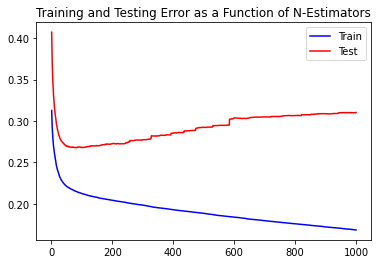

In [19]:
#plot seeing if we overfit

#define a log loss function
def LogLossP(Pt, Yt):
    return -1*((Yt==1)*np.log(Pt)+(Yt==0)*np.log(1-Pt)).mean()

#get the probabilities at each iteration
p_train = gbc.staged_predict_proba(X_train)
p_test = gbc.staged_predict_proba(X_test)

#initiate lists to store log loss
ll_train = []
ll_test = []

#loop through each calculating log loss at each iterative tree
for p in p_train:
    ll_train.append(LogLossP(p[:, 1], Y_train_cl.to_numpy().ravel()))
    
for p in p_test:
    ll_test.append(LogLossP(p[:, 1], Y_test_cl.to_numpy().ravel()))
    
#plot this
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, n_est_lim + 1), ll_train, 'b-', label='Train')
plt.plot(np.arange(1, n_est_lim + 1), ll_test, 'r-', label='Test')
plt.title('Training and Testing Error as a Function of N-Estimators')
plt.legend()

In [15]:
#starting with max depth=2 trying 200 trees
gbc_2 = GradientBoostingClassifier(n_estimators = 200, max_depth = 2)
gbc_2.fit(X_train, Y_train_cl.to_numpy().ravel())

GradientBoostingClassifier(max_depth=2, n_estimators=200)

In [42]:
#checking for fewer trees
y_test_cl_arr
preds_gbc_2 = gbc_2.predict(X_test)
preds_gbc_2_probs = gbc_2.predict_proba(X_test)

#plot confusion
print(confusion_matrix(y_test_cl_arr,preds_gbc_2))

#get precision and recall scores
print(classification_report(y_test_cl_arr, preds_gbc_2))

[[2939   71]
 [ 333  221]]
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      3010
           1       0.76      0.40      0.52       554

    accuracy                           0.89      3564
   macro avg       0.83      0.69      0.73      3564
weighted avg       0.88      0.89      0.87      3564



the overall log loss is better with 200 trees, however those improvements come from precision, not recall

In [48]:
#plot an auc curve
auc_1000 = roc_auc_score(y_test_cl_arr,preds_gbc_prob[:,1])
auc_200 = roc_auc_score(y_test_cl_arr,preds_gbc_2_probs[:,1])

#get rocs
fpr_1000, tpr_1000, thresh_1000 = roc_curve(y_test_cl_arr,preds_gbc_prob[:,1])
fpr_200, tpr_200, thresh_200 = roc_curve(y_test_cl_arr,preds_gbc_2_probs[:,1])

aucs = [auc_1000, auc_200]
fprs = [fpr_1000, fpr_200]
tprs = [tpr_1000, tpr_200]
labels = ['1000 trees', '200 trees']

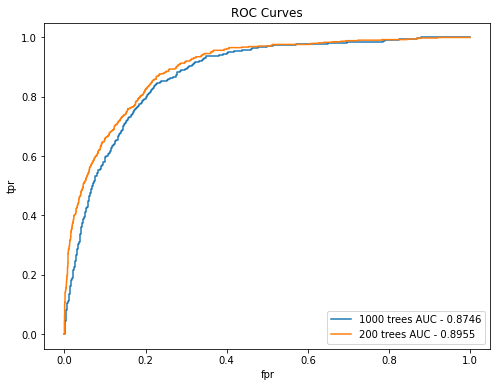

In [51]:
#plot each of the 4 curves
plt.figure(figsize=(8,6))
for fpr, tpr, label, auc in zip(fprs, tprs, labels, aucs):
    labauc = label+" AUC - "+str(round(auc,4))
    plt.plot(fpr, tpr, label=labauc)
    
    
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.show()    

# OOB Gradient Boosting for Class Size

In [10]:
#classifying class sizing -- no hyperparameter tuning
gbc_size_oob = GradientBoostingClassifier().fit(X_train, Y_train_cl_size.to_numpy().ravel())
#checking for fewer trees
preds_gbc_oob = gbc_size_oob.predict(X_test)



#plot confusion
print(confusion_matrix(Y_test_cl_size.to_numpy().ravel(),preds_gbc_oob))

#get precision and recall scores
print(classification_report(Y_test_cl_size.to_numpy().ravel(), preds_gbc_oob))

[[2953   22    9   12   14]
 [ 230   32    7    3    6]
 [ 110    4    6    4    4]
 [  44    9    1   11    1]
 [  35    3    3    7   34]]
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      3010
           1       0.46      0.12      0.18       278
           2       0.23      0.05      0.08       128
           3       0.30      0.17      0.21        66
           4       0.58      0.41      0.48        82

    accuracy                           0.85      3564
   macro avg       0.49      0.34      0.38      3564
weighted avg       0.80      0.85      0.81      3564



In [20]:
#send all GBCs to pkls

gbc1_load_path = os.path.join(code_dir, 'model_dev/GBCbin_1000trees_1122JE')
pickle.dump(gbc, open(gbc1_load_path, "wb"))

gbc2_load_path = os.path.join(code_dir, 'model_dev/GBCbin_200trees_1122JE')
pickle.dump(gbc_2, open(gbc2_load_path, "wb"))

gbc3_load_path = os.path.join(code_dir, 'model_dev/GBCsize_OOB_1122JE')
pickle.dump(gbc_size_oob, open(gbc3_load_path, "wb"))